# Evaluation of Profile detector

### Environment

Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path

import torch

from torch.utils.data import DataLoader, random_split

from test import confusion, evaluate
from dataset import ProfileDataset, get_balanced_sampler
from model import ProfileDetector

Config

In [2]:
TRAIN_DATA_PATH = '../Dataset'
TEST_DATA_PATH = '../Dataset'
MODEL_DIR = '../trained_models'
MODEL_NAME = 'profile_detector_mlr_val'

Make plots wider

In [3]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10, 5)

### Model and dataset

In [4]:
model_path = Path(MODEL_DIR) / f'{MODEL_NAME}_final'
model = ProfileDetector(pretrained=True, freeze_backbone=True)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
dataset = ProfileDataset(TRAIN_DATA_PATH, augment=False)

generator = torch.Generator().manual_seed(42)
_, val_dataset = random_split(dataset, [0.90, 0.10], generator)
sampler = get_balanced_sampler(val_dataset, dataset.targets, 0.90, generator)
val_loader = DataLoader(val_dataset, batch_size=64, sampler=sampler, generator=generator)
print(f"Loaded validation dataset with {len(val_dataset)} images.")

Loaded validation dataset with 165 images.


In [6]:
test_dataset = ProfileDataset(TEST_DATA_PATH, augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Loaded test dataset with {len(test_dataset)} images.")

Loaded test dataset with 720 images.


In [7]:
dist = sum(1 for t in dataset.targets if t) / len(dataset)
print("Data distribution in training data:\t{:.1f}% (good) / {:.1f}% (bad)".format(dist*100, 100-dist*100))
dist = sum(1 for t in test_dataset.targets if t) / len(test_dataset)
print("Data distribution in test data:\t\t{:.1f}% (good) / {:.1f}% (bad)".format(dist*100, 100-dist*100))

Data distribution in training data:	39.1% (good) / 60.9% (bad)
Data distribution in test data:		47.6% (good) / 52.4% (bad)


Select data to plot

In [8]:
data_loader = val_loader

### Load loss and accuracy

In [9]:
metrics_path = Path(MODEL_DIR) / f'{MODEL_NAME}_metrics.csv'
metrics = pd.read_csv(metrics_path)

### Plot loss

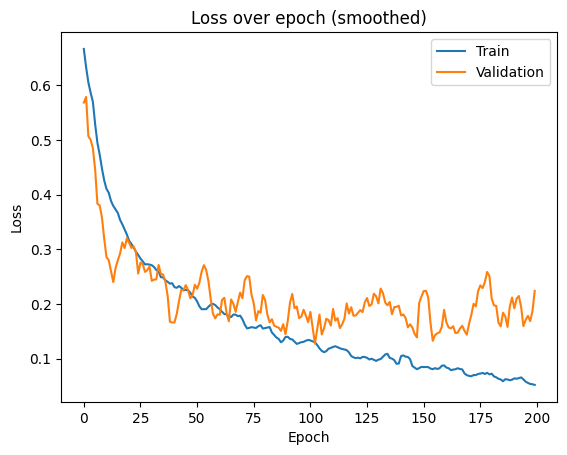

In [10]:
window_size = 5

s_metrics = metrics[['train loss', 'validation loss']].copy()
s_metrics['train loss'] = metrics['train loss'].rolling(window_size, 1).mean()
s_metrics['validation loss'] = metrics['validation loss'].rolling(window_size, 1).mean()

s_metrics.plot(y=['train loss', 'validation loss'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch (smoothed)')
plt.legend(['Train', 'Validation'])

plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_loss_smooth.pdf')

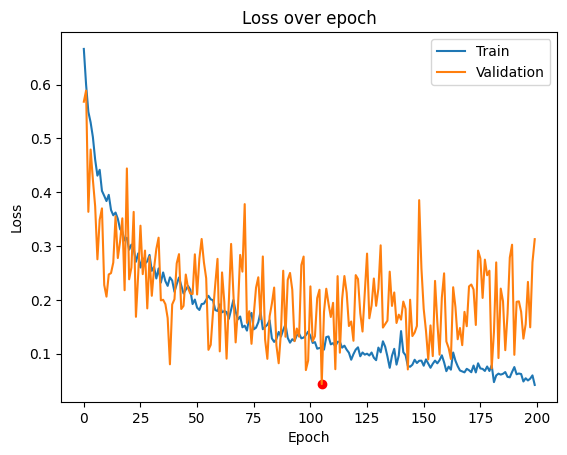

In [11]:
metrics.plot(y=['train loss', 'validation loss'], kind='line')

best_epoch = metrics['validation loss'].idxmin()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation loss'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_loss.pdf')

### Plot accuracy

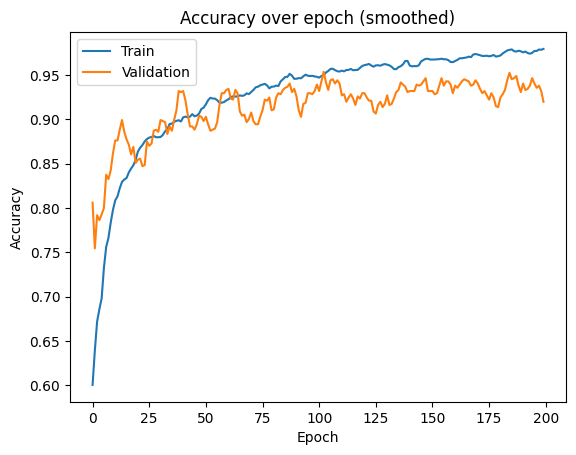

In [12]:
window_size = 5

s_metrics = metrics[['train accuracy', 'validation accuracy']].copy()
s_metrics['train accuracy'] = metrics['train accuracy'].rolling(window_size, 1).mean()
s_metrics['validation accuracy'] = metrics['validation accuracy'].rolling(window_size, 1).mean()

s_metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_acc_smooth.pdf')

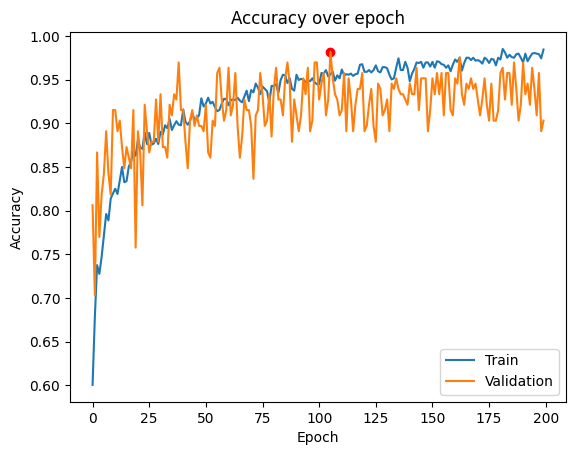

In [13]:
metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

best_epoch = metrics['validation accuracy'].idxmax()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation accuracy'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_acc.pdf')

### Combined loss and accuracy plots 

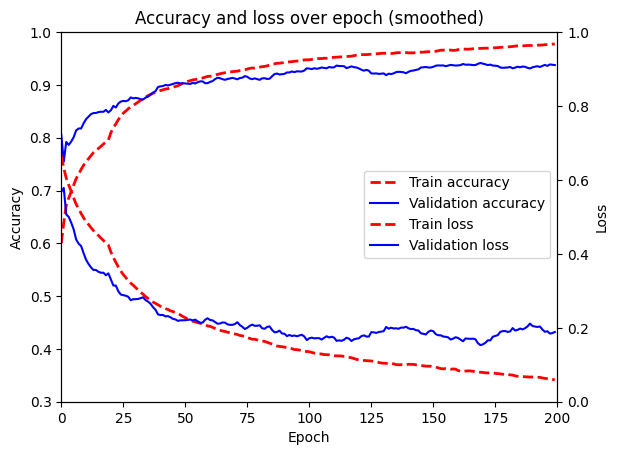

In [14]:
window_size = 20
s_metrics = metrics.copy()
s_metrics['train loss'] = metrics['train loss'].rolling(window_size, 1).mean()
s_metrics['train accuracy'] = metrics['train accuracy'].rolling(window_size, 1).mean()
s_metrics['validation loss'] = metrics['validation loss'].rolling(window_size, 1).mean()
s_metrics['validation accuracy'] = metrics['validation accuracy'].rolling(window_size, 1).mean()

fig, ax1 = plt.subplots()
ax1.plot(s_metrics['train accuracy'], label="Train accuracy", linestyle='--', color="red", lw=2)
ax1.plot(s_metrics['validation accuracy'], label="Validation accuracy", linestyle='-', color="blue")
ax1.set_ylim(0.3, 1)

ax2 = ax1.twinx()
ax2.plot(s_metrics['train loss'], label="Train loss", linestyle='--', color="red", lw=2)
ax2.plot(s_metrics['validation loss'], label="Validation loss", linestyle='-', color="blue")
ax2.set_ylim(0, 1)

ax1.set_xlabel('Epoch')
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Loss")

ax1.set_xlim(0,200)
# fig.legend(loc="center right", bbox_to_anchor=(0.43, 0.21))
fig.legend(loc="center right", bbox_to_anchor=(0.9, 0.5))
plt.title('Accuracy and loss over epoch (smoothed)')
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_acc_loss_smooth.pdf')

### Create predictions

In [15]:
outs = torch.empty((0, 1))
targets = torch.empty((0, 1))
imgs = []
with torch.no_grad():
    for input, target, ix in data_loader:
        input.requires_grad_(False)
        model.eval()
        out = model(input)
        outs = torch.cat([outs, out])
        targets = torch.cat([targets, target])
        imgs.extend([data_loader.dataset.dataset.image_paths[i] for i in ix])

print(outs.shape)

torch.Size([165, 1])


### Confusion matrix

In [16]:
print("Confusion matrix at t=0.1")
cm = confusion(outs, targets, thresh=0.1)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.25")
cm = confusion(outs, targets, thresh=0.25)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.5")
cm = confusion(outs, targets, thresh=0.5)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.75")
cm = confusion(outs, targets, thresh=0.75)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.9")
cm = confusion(outs, targets, thresh=0.9)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

Confusion matrix at t=0.1
P: 0.455, R: 0.938, F1: 0.612, Acc: 0.885
[[131  18]
 [  1  15]]
Confusion matrix at t=0.25
P: 0.556, R: 0.938, F1: 0.698, Acc: 0.921
[[137  12]
 [  1  15]]
Confusion matrix at t=0.5
P: 0.619, R: 0.812, F1: 0.703, Acc: 0.933
[[141   8]
 [  3  13]]
Confusion matrix at t=0.75
P: 0.684, R: 0.812, F1: 0.743, Acc: 0.945
[[143   6]
 [  3  13]]
Confusion matrix at t=0.9
P: 0.800, R: 0.750, F1: 0.774, Acc: 0.958
[[146   3]
 [  4  12]]


## Performance at threshold

In [17]:
print("Confusion matrix at t=0.8")
random_guess = torch.zeros_like(targets).uniform_(0, 1000) > (500)
cm = confusion(random_guess, targets, thresh=0.8)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

Confusion matrix at t=0.8
P: 0.129, R: 0.688, F1: 0.218, Acc: 0.521
[[75 74]
 [ 5 11]]


### Compute threshold metrics

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

thresholds = np.arange(0.0, 1.01, 0.01)

f1s, accs = [], []
for thresh in thresholds:
    cm = confusion(outs, targets, thresh=thresh)
    p, r, f1, acc = evaluate(cm)
    f1s, accs = [*f1s, f1], [*accs, acc]

prc_precision, prc_recall, prc_thresholds = precision_recall_curve(targets, outs)
prc_thresholds = np.append(prc_thresholds, 1.0)
prc_auc = average_precision_score(targets, outs)
prc_id = (prc_precision + prc_recall).argsort()[::-1].tolist()[0]
prec_opt = (prc_recall[prc_id], prc_precision[prc_id], prc_thresholds[prc_id])

fpr, tpr, threshs = roc_curve(targets, outs)
roc_auc = auc(fpr, tpr)

t_10_fpr = [t for i, t in enumerate(threshs) if fpr[i] < 0.10][-1]
t_05_fpr = [t for i, t in enumerate(threshs) if fpr[i] < 0.05][-1]

c:\Users\victo\Documents\Linköpings Universitet\5\TSBB11\emotioncapture\profile_detector\test.py:27: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])


### Performance at difference thresholds

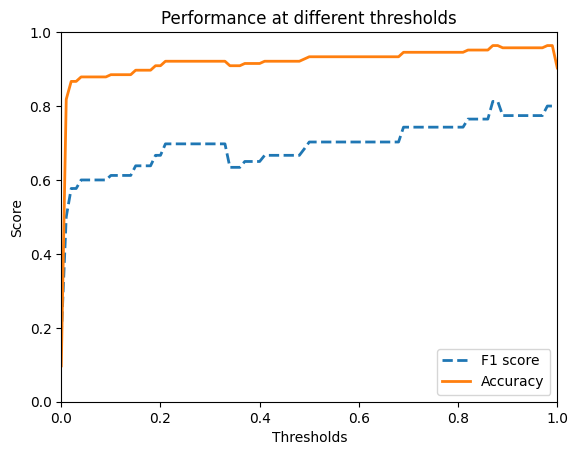

In [19]:
plt.plot(thresholds, f1s, label="F1 score", linestyle='--', lw=2)
plt.plot(thresholds, accs, label="Accuracy", linestyle='-', lw=2)
plt.legend(loc="lower right")
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Performance at different thresholds')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_performance.pdf')

### Precision-recall curve

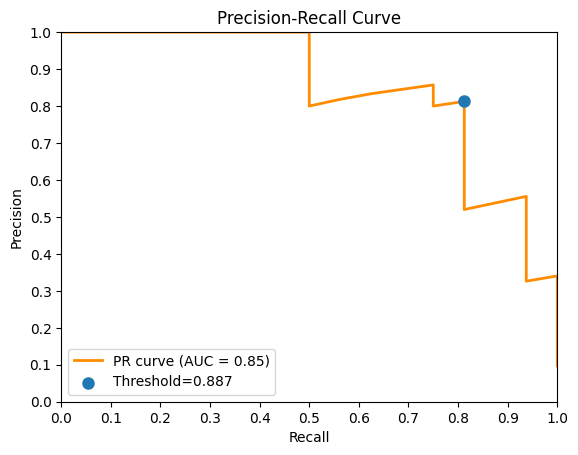

In [20]:
plt.plot(prc_recall, prc_precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % prc_auc, zorder=0)
plt.scatter(prc_recall[prc_id], prc_precision[prc_id], marker='o', lw=3, label='Threshold={:.3f}'.format(prc_thresholds[prc_id]), zorder=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower left')
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_perrec.pdf')

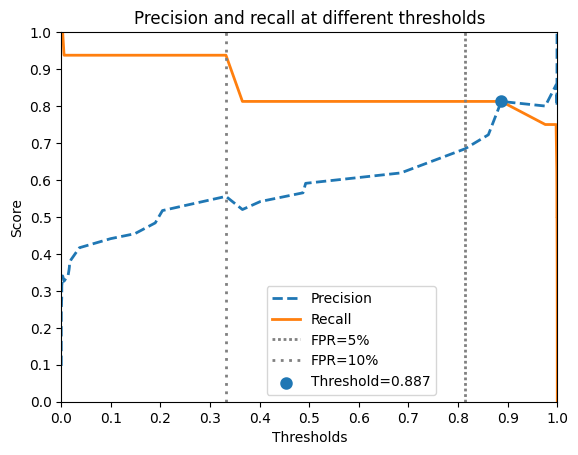

In [21]:
plt.plot(prc_thresholds, prc_precision, label="Precision", linestyle='--', lw=2)
plt.plot(prc_thresholds, prc_recall, label="Recall", linestyle='-', lw=2)
plt.plot([t_05_fpr, t_05_fpr], [0, 1], linestyle=(0, (1, 1)), color="grey", label='FPR=5%', lw=2, zorder=2)
plt.plot([t_10_fpr, t_10_fpr], [0, 1], linestyle=(0, (1, 2)), color="grey", label='FPR=10%', lw=2, zorder=2)
plt.scatter(prec_opt[2], prec_opt[0], marker='o', lw=3, label='Threshold={:.3f}'.format(prec_opt[2]), zorder=3)
plt.legend(loc="lower left", bbox_to_anchor=(0.4,0))
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Precision and recall at different thresholds')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_perrec.pdf')

### ROC curve

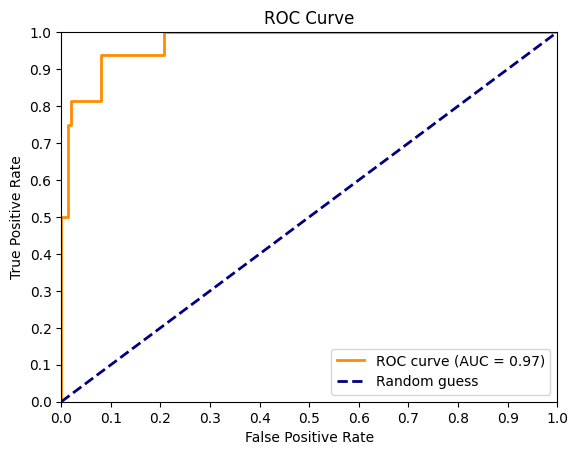

In [22]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_roc.pdf')

## Qualtive evaluation

In [23]:
nr_samples = 5

good_ids = torch.argsort((outs - targets).abs().flatten(), descending=False).tolist()
good_predictions: dict[int, Path] = {}
i_p, i_n = 0, 0
for id in good_ids:
    if i_p == nr_samples and i_n == nr_samples:
        break

    val = (imgs[id], outs[id].item(), targets[id].item())
    if val in good_predictions.values():
        continue

    if val[2] > 0.5 and i_p < nr_samples:
        good_predictions[id] = val
        i_p += 1
    if val[2] < 0.5 and i_n < nr_samples:
        good_predictions[id] = val
        i_n += 1


bad_predictions: dict[int, (Path, float, int)] = {}
bad_ids = torch.argsort((outs - targets).abs().flatten(), descending=True).tolist()
i_p, i_n = 0, 0
for id in bad_ids:
    if i_p == nr_samples and i_n == nr_samples:
        break

    val = (imgs[id], outs[id].item(), targets[id].item())
    if val in good_predictions.values():
        continue

    if val[2] > 0.5 and i_p < nr_samples:
        bad_predictions[id] = val
        i_p += 1
    if val[2] < 0.5 and i_n < nr_samples:
        bad_predictions[id] = val
        i_n += 1

unsure_predictions: dict[int, (Path, float, int)] = {}
unsure_ids = torch.argsort((outs - 0.8).abs().flatten(), descending=False).tolist()
i_p, i_n = 0, 0
for id in unsure_ids:
    if i_p == nr_samples and i_n == nr_samples:
        break

    val = (imgs[id], outs[id].item(), targets[id].item())
    if val in good_predictions.values():
        continue

    if val[2] > 0.5 and i_p < nr_samples:
        unsure_predictions[id] = val
        i_p += 1
    if val[2] < 0.5 and i_n < nr_samples:
        unsure_predictions[id] = val
        i_n += 1

print("Good:", [path.name for path, out,
      target in good_predictions.values() if target > 0])
print("Bad:", [path.name for path, out,
      target in bad_predictions.values() if target > 0])
print("Unsure:", [path.name for path, out,
      target in bad_predictions.values() if target > 0])

Good: ['002446-2022-05-23_10-03-49_frame2657.jpg', 'G3F3_frame19180.jpg', 'G3F1_frame23954.jpg', 'G8M1-baseline_frame16721.jpg', 'G3F1_frame15712.jpg']
Bad: ['G2F2-baseline_frame45339.jpg', '002446-2022-05-23_10-03-49_frame12837.jpg', '002446-2022-05-23_10-03-49_frame12837.jpg', '018757-2023-06-08_08-53-33_frame36702.jpg', 'G8M1-baseline_frame24790.jpg']
Unsure: ['G2F2-baseline_frame45339.jpg', '002446-2022-05-23_10-03-49_frame12837.jpg', '002446-2022-05-23_10-03-49_frame12837.jpg', '018757-2023-06-08_08-53-33_frame36702.jpg', 'G8M1-baseline_frame24790.jpg']


In [ ]:
from IPython.display import display, Image

for id, img in good_predictions.items():
    path, out, target = img
    display(Image(path))
    print("{} | Prediction: {:.2f}%, Actual: {}".format(path.name, out*100, "Yes" if target else "No"))

In [ ]:
for id, img in bad_predictions.items():
    path, out, target = img
    display(Image(path))
    print("{} | Prediction: {:.2f}%, Actual: {}".format(path.name, out*100, "Yes" if target else "No"))

In [ ]:
for id, img in unsure_predictions.items():
    path, out, target = img
    display(Image(path))
    print("{} | Prediction: {:.2f}%, Actual: {}".format(path.name, out*100, "Yes" if target else "No"))